# Multivariate Gaussian Distributions: Marginalization and Conditioning

In [2]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
mu_all = np.zeros(2)
cov_one = np.array([[1.0, 0.5], [0.5, 1.0]])
cov_two = np.array([[1.0, 0.0], [0.0, 1.0]])
cov_three = np.array([[1.0, -0.5], [-0.5, 1.0]])

### Multivariate Gaussian PDF Implementation

In [4]:
def multivariate_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray) -> float:
    """
    Calculates the probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.

    Returns:
        Probability density function value at location x_vec.
    """
    x = np.asarray(x_vec, dtype=float)
    mu = np.asarray(mu_vec, dtype=float)
    Sigma = np.asarray(covariance_matrix, dtype=float)

    d = x.shape[0]
    x_c = x - mu
    cov_det = np.linalg.det(Sigma)
    norm = 1/(pow(2*np.pi, d/2) * np.sqrt(cov_det))

    return norm * np.exp(-0.5 * np.transpose(x_c) @ np.linalg.inv(Sigma) @ x_c)

In [5]:
test_point = np.array([1.01, 0.22])
my_pdf = multivariate_gaussian_pdf(test_point, mu_all, cov_one)
scipy_pdf = stats.multivariate_normal.pdf(test_point, mu_all, cov_one)
assert np.round(my_pdf - scipy_pdf, 6) == 0, "The two values do not agree. Did you forget the terms outside the exponential?"

Comparing the time taken by the above function to scipy

In [6]:
%%timeit
multivariate_gaussian_pdf(test_point, mu_all, cov_one)

18.8 μs ± 3.05 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
stats.multivariate_normal.pdf(test_point, mu_all, cov_one)

105 μs ± 8.25 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Our NumPy implementation is significantly faster (~18.6 µs vs ~105 µs) because scipy.stats revalidates inputs and reconstructs the distribution on every call.

In [8]:
# We can use numpy's vectorize capability to vectorize our pdf function.
mg_pdf_vectorized = np.vectorize(multivariate_gaussian_pdf, signature='(n), (n), (n,n) -> ()')

# We can also use numpy's meshgrid to get the points to evaluate
x1_points, x2_points = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
x_vec_points = np.stack([x1_points, x2_points], axis=-1)

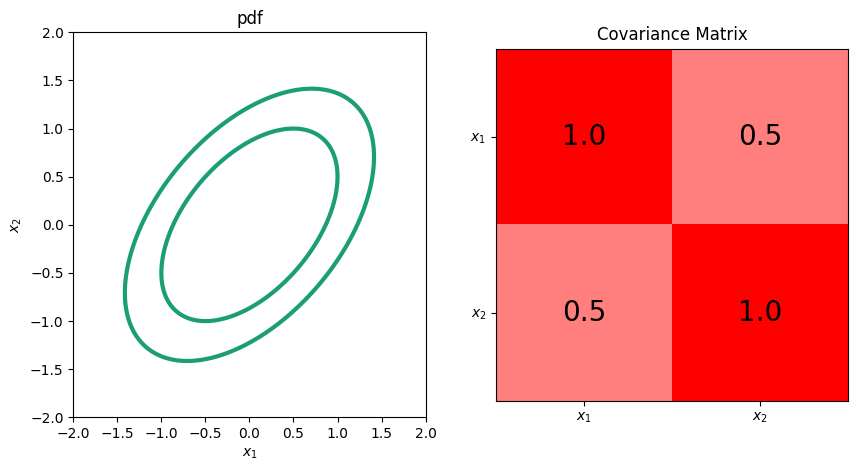

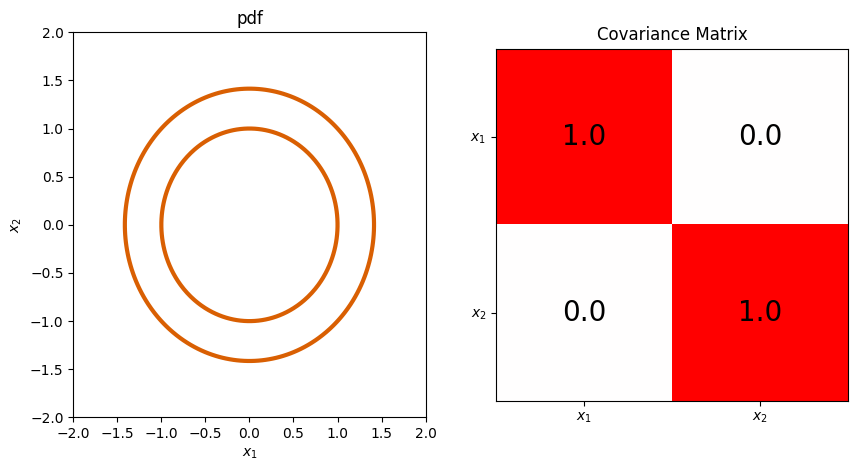

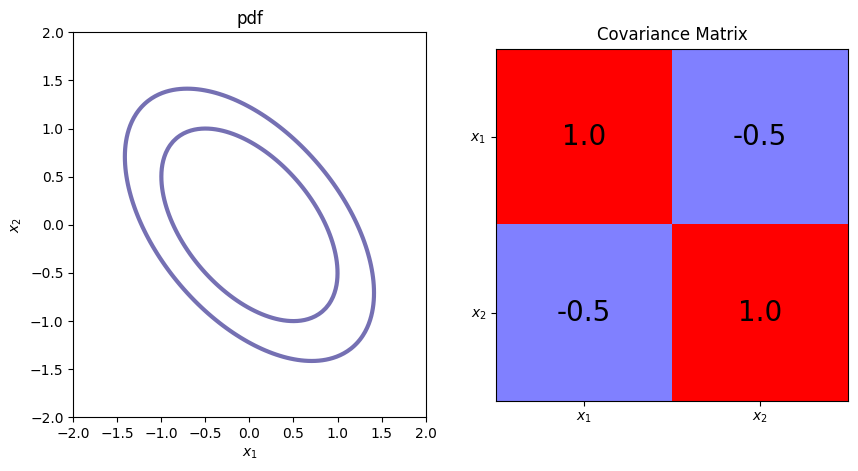

In [9]:
def plot_pdf_and_covariance(covariance_matrix:np.ndarray, color='black'):
    # Use the vectorized function to evaluate the pdf.
    pdf_evaluations = mg_pdf_vectorized(x_vec_points, mu_all, covariance_matrix)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].contour(x1_points, x2_points, pdf_evaluations/np.max(pdf_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors=color, linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_2$')
    ax[0].set_title('pdf')
    ax[1].imshow(covariance_matrix, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_title('Covariance Matrix')

    for x_1 in range(2):
        for x_2 in range(2):
            ax[1].text(x_1, x_2, covariance_matrix[x_1, x_2], fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(cov_one, '#1b9e77')
plot_pdf_and_covariance(cov_two, '#d95f02')
plot_pdf_and_covariance(cov_three, '#7570b3')

### Marginal Distribution of Multivariate Gaussian Distribution 

In [10]:
def marginal_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, marginal_index:int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the marginalized mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Mean and covariance of marginalized Gaussian.
    """

    mu = np.asarray(mu_vec, dtype=float)
    Sigma = np.asarray(covariance_matrix, dtype=float)

    n = mu.shape[0]

    perm = []
    for i in range(n):
        if (i != marginal_index):
            perm.append(i)

    perm.append(marginal_index)

    mu_perm = mu[perm]
    cov_perm = Sigma[np.ix_(perm, perm)]

    marginal_mu = mu_perm[:-1]
    marginal_cov = cov_perm[:-1, :-1]

    return marginal_mu, marginal_cov

### Marginal Gaussian PDF

In [11]:
def marginal_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             marginal_index:int) -> float:
    """
    Calculates the marginalized probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_marg, cov_marg = marginal_mean_covariance(mu_vec, covariance_matrix, marginal_index)

    return multivariate_gaussian_pdf(x_vec, mu_marg, cov_marg)

### Conditional Distribution of Multivariate Gaussian Distribution 

In [12]:
def conditioned_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, condition_index:int, 
                                condition_value:float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the conditioned mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Mean and covariance of conditioned Gaussian.
    """
    
    mu = np.asarray(mu_vec, dtype=float)
    Sigma = np.asarray(covariance_matrix, dtype=float)

    n = mu.shape[0]

    perm = []
    for i in range(n):
        if (i != condition_index):
            perm.append(i)

    perm.append(condition_index)

    mu_perm = mu[perm]
    cov_perm = Sigma[np.ix_(perm, perm)]

    mu_a = mu_perm[:-1]
    mu_b = float(mu_perm[-1])
    s_AA = cov_perm[:-1, :-1]
    s_AB = cov_perm[:-1, -1]
    s_BA = cov_perm[-1, :-1]
    s_BB = float(cov_perm[-1, -1])

    conditional_mu = mu_a + (s_AB/s_BB) * (condition_value - mu_b)
    conditional_cov = s_AA - ((np.outer(s_AB, s_BA)) / s_BB)

    return conditional_mu, conditional_cov

### Conditional Gaussian PDF

In [13]:
def conditioned_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             condition_index:int, condition_value:float) -> float:
    """
    Calculates the conditioned probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_cond, cov_cond = conditioned_mean_covariance(mu_vec, covariance_matrix, condition_index, condition_value)

    return multivariate_gaussian_pdf(x_vec, mu_cond, cov_cond)

In [14]:
# Let's test our functions to make sure they give the right values.
# This block will output nothing if the code above is correct.
# Test the marginal
mu_four = np.array([0.2, 0.3, -0.2])
cov_four = np.array([[1.0, 0.5, 0.2],[0.5, 1.0, 0.5], [0.2, 0.5, 1.0]])
my_mean, my_covariance = marginal_mean_covariance(mu_four, cov_four, marginal_index=1)
correct_mean, correct_covariance = (np.array([0.2, -0.2]), np.array([[1.0, 0.2],[0.2, 1.0]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

# Test the conditional
my_mean, my_covariance = conditioned_mean_covariance(mu_four, cov_four, condition_index=1, condition_value=1.3)
correct_mean, correct_covariance = (np.array([0.7, 0.3]), np.array([[0.75, -0.05],[-0.05, 0.75]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

Let's consider our three-dimensional covariance matrix and see how marginalizing changes the distribution.

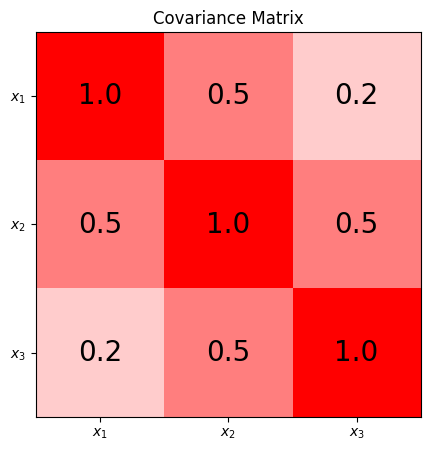

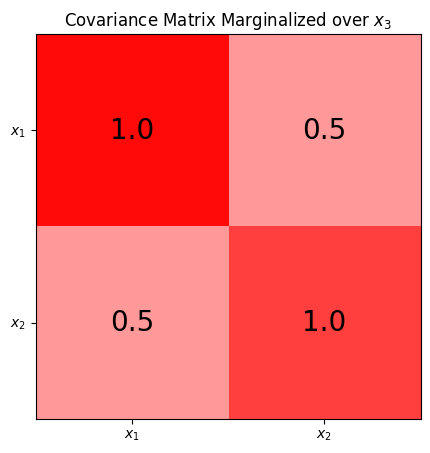

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(cov_four, cmap='bwr', vmax=1, vmin=-1)
ax.set_xticks([0,1,2])
ax.set_xticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_yticks([0,1,2])
ax.set_yticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_title('Covariance Matrix')

for x_1 in range(3):
    for x_2 in range(3):
        ax.text(x_1, x_2, cov_four[x_1, x_2], fontsize=20, ha='center', va='center')

fig, ax = plt.subplots(1, 1, figsize=(10,5))
_, cov_marg_x_three = conditioned_mean_covariance(mu_four, cov_four, condition_index=2, condition_value=0.0)
ax.imshow(cov_marg_x_three, cmap='bwr', vmax=1, vmin=-1)
ax.set_xticks([0,1])
ax.set_xticklabels([r'$x_1$',r'$x_2$'])
ax.set_yticks([0,1])
ax.set_yticklabels([r'$x_1$',r'$x_2$'])
ax.set_title(r'Covariance Matrix Marginalized over $x_3$')

for x_1 in range(2):
    for x_2 in range(2):
        ax.text(x_1, x_2, cov_four[x_1, x_2], fontsize=20, ha='center', va='center')

plt.show()

In [16]:
mg_pdf_vectorized = np.vectorize(marginal_gaussian_pdf, signature='(n), (m), (m,m), () -> ()')
cg_pdf_vectorized = np.vectorize(conditioned_gaussian_pdf, signature='(n), (m), (m,m), (), () -> ()')

x1_points, x3_points = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
x_vec_points = np.stack([x1_points, x3_points], axis=-1)

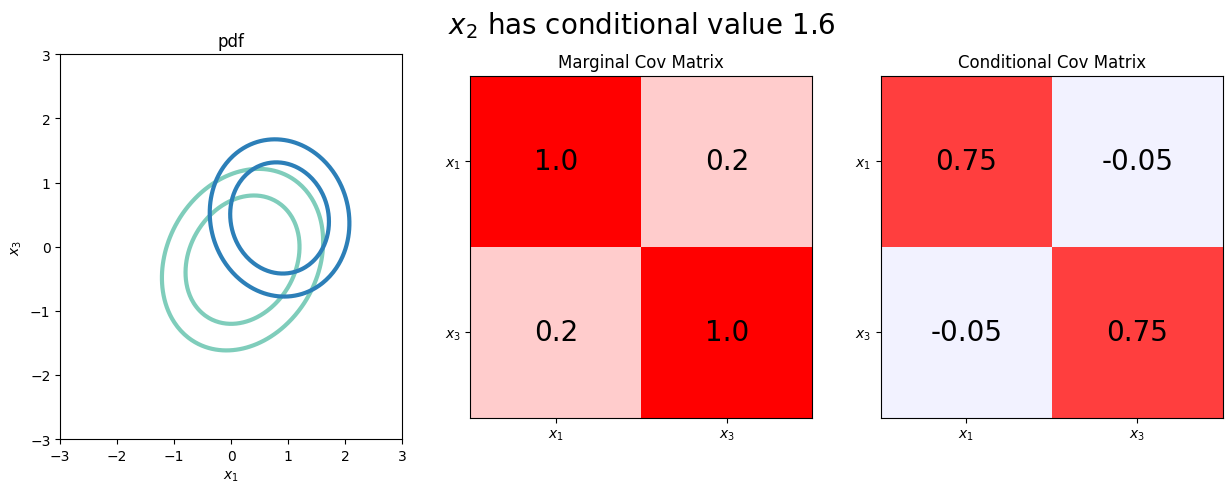

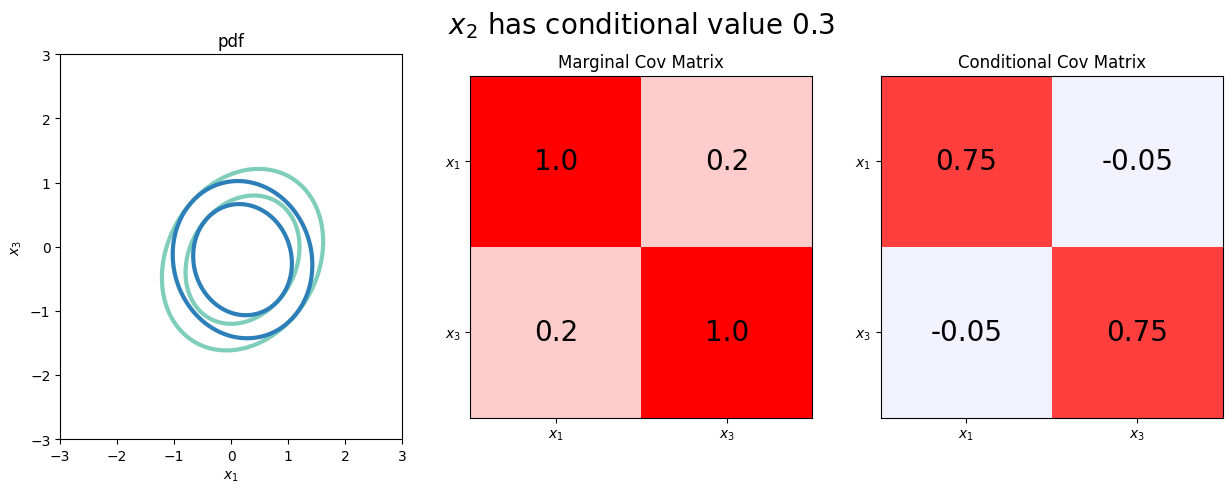

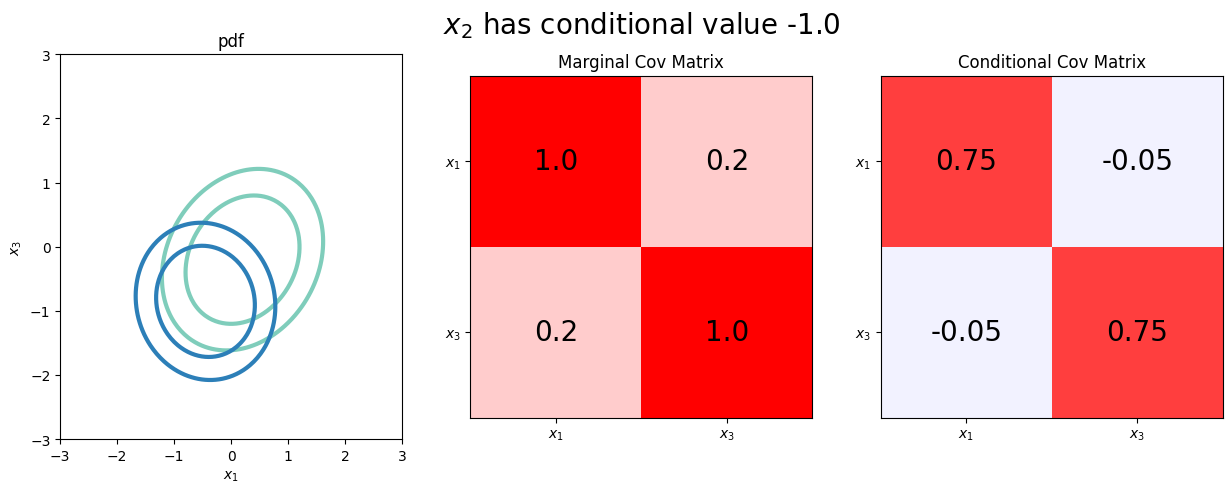

In [17]:
def plot_pdf_and_covariance(conditional_index:int, conditional_value:float):

    marginal_evaluations = mg_pdf_vectorized(x_vec_points, mu_four, cov_four, marginal_index=conditional_index)
    conditional_evaluations = cg_pdf_vectorized(x_vec_points, mu_four, cov_four, conditional_index, conditional_value)
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].contour(x1_points, x3_points, marginal_evaluations/np.max(marginal_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#7fcdbb', linewidths=3)
    ax[0].contour(x1_points, x3_points, conditional_evaluations/np.max(conditional_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#2c7fb8', linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_3$')
    ax[0].set_title('pdf')

    _, cov_marginal = marginal_mean_covariance(mu_four, cov_four, marginal_index=conditional_index)
    ax[1].imshow(cov_marginal, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_3$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_3$'])
    ax[1].set_title('Marginal Cov Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[1].text(x_1, x_3, cov_marginal[x_1, x_3], fontsize=20, ha='center', va='center')

    ax[1].text(0.5, -0.8, r'$x_2$ has conditional value ' + f'{conditional_value}', fontsize=20, ha='center', va='center')

    _, cov_conditional = conditioned_mean_covariance(mu_four, cov_four, conditional_index, conditional_value)
    ax[2].imshow(cov_conditional, cmap='bwr', vmax=1, vmin=-1)
    ax[2].set_xticks([0,1])
    ax[2].set_xticklabels([r'$x_1$',r'$x_3$'])
    ax[2].set_yticks([0,1])
    ax[2].set_yticklabels([r'$x_1$',r'$x_3$'])
    ax[2].set_title('Conditional Cov Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[2].text(x_1, x_3, np.round(cov_conditional[x_1, x_3],2), fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(1, 1.6)
plot_pdf_and_covariance(1, 0.3)
plot_pdf_and_covariance(1, -1.0)

Calculate the marginal mean and covariance when marginalizing over x2 (index=1):

In [19]:
my_mean, my_covariance = marginal_mean_covariance(
    mu_four, cov_four, marginal_index=1)

my_mean, my_covariance

(array([ 0.2, -0.2]),
 array([[1. , 0.2],
        [0.2, 1. ]]))

Calculate the conditional mean and covariance when conditioning on x2 = 1.3 (index=1):

In [21]:
my_mean, my_covariance = conditioned_mean_covariance(
    mu_four, cov_four, condition_index=1, condition_value=1.3)

my_mean, my_covariance

(array([0.7, 0.3]),
 array([[ 0.75, -0.05],
        [-0.05,  0.75]]))